<a href="https://colab.research.google.com/github/MattiaPOLI/DR14/blob/nico/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ~-----enable Colab to load CSV-----
# import useful libraries
from google.colab import files

# specify the file to load
uploaded = files.upload()

Saving Sky.csv to Sky.csv


In [2]:
# ~-----import libraries-----
import pandas as pd
import numpy as np
import io
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# ~-----load desired data-----
# store data in a Pandas dataframe
df = pd.read_csv(io.StringIO(uploaded['Sky.csv'].decode('utf-8')), sep=',', header=0)


# ~-----data cleaning-----
# drop the following useless features:
#   - objid, specobjid: numerical ID of the celestial body
#   - run, rerun, camcol, field: parameters used to identify from which scan data are taken
#   - plate, mjd, fiberid: parameters related to the used laboratory equipment
df_cleaned = df.drop( columns=['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'plate', 'mjd', 'fiberid'] )

# remove missing values
df_cleaned = df_cleaned.dropna()


# ~-----retrieve predictors and response variables-----
# get predictors
X = df_cleaned

# extract class label from the dataframe
y = X.pop('class')

# determine available classes
classes = np.unique(y.values).tolist()
class_code = {classes[k]: k for k in range(3)}
y_colors = [class_code[cl] for cl in y]


# ~-----normalize data-----
# create standard scaler object
scaler = StandardScaler().fit(X)

# normalize predictors
X_norm = scaler.transform(X)


# ~-----PCA-----
# create PCA object
pca = PCA().fit(X_norm)

# find new space
X_pca = pca.transform(X_norm)

# exploit most expressive PCs (first 5)
X_ready = X_pca[:, 0:5]


# ~-----visualize results-----
print (class_code)

print ('X= ' + str(X_ready.shape))
print ('y= ' + str(y.shape))

X_ready.view()

{'GALAXY': 0, 'QSO': 1, 'STAR': 2}
X= (10000, 5)
y= (10000,)


array([[-1.15239766, -0.66539039, -0.33234926, -0.67354267, -1.36838363],
       [-0.28088579, -0.58065913, -0.31886281, -0.1621427 ,  0.07913557],
       [ 1.30200395, -0.71285814, -0.29406976, -0.40156115, -0.374463  ],
       ...,
       [ 1.19407769,  0.95603664,  1.27248572, -0.70834838,  0.71192935],
       [ 1.19456035,  0.94259761,  1.27511444, -0.78434171,  0.45373058],
       [-0.56639967,  1.04184989,  1.24786673, -0.83216437, -1.10842779]])

In [0]:
# ~-----import libraries-----
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn


# ~-----create training and testing sets-----
X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.3, random_state=42)


# ~-----generally valid variables-----
C_range = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
gamma_range = np.array([1e-9, 1e-7, 1e-5, 1e-3])

======= Linear SVM =======
C=0.001   	--> 77.32%
C=0.01   	--> 85.34%
C=0.1   	--> 95.20%
C=1.0   	--> 97.83%
C=10.0   	--> 98.26%
C=100.0   	--> 98.29%
C=1000.0   	--> 98.33%

Best C=   	1000.0


No handles with labels found to put in legend.


Test accuracy= 	98.20%


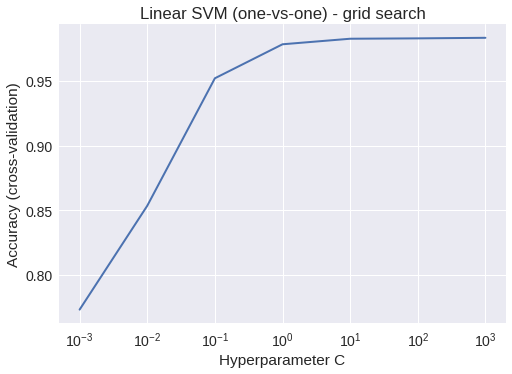

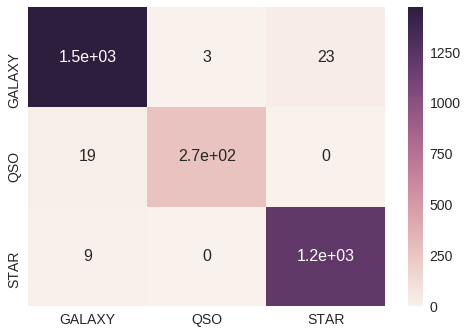

In [8]:
# ~-----linear SVM (one-vs-one)-----
# auxiliary variables
accuracy_validation = []
score_max = 0
C_best_linear = 0

# optimizes parameters
print("======= Linear SVM =======")
for C in C_range:
    model = svm.SVC(kernel='linear', C=C)
    scores = cross_val_score(model, X_train, y_train, cv=10)
    avg = np.mean(scores)
    accuracy_validation.append(avg)
    print("C=" + str(C) + "   \t--> %.2f%%" % (avg*100))
    if (avg > score_max):
        score_max = avg
        C_best_linear = C
            
print("\nBest C=   \t" + str(C_best_linear))


# ~-----create best SVM-----
# train model
svc_linear_one = svm.SVC(kernel='linear', C=C_best_linear)
svc_linear_one.fit(X_train, y_train)

# evaluate classificator on testing set
accuracy = svc_linear_one.score(X_test, y_test)

print("Test accuracy= \t%.2f%%" % (accuracy*100))


# ~-----visualize results-----
# accuracy w.r.t. parameters
fig = plt.figure()
ax = fig.gca()
plt.plot(C_range, accuracy_validation, linewidth=2)#, label='average accuracy on cross validation')
plt.xscale("log")
plt.title('Linear SVM (one-vs-one) - grid search')
plt.xlabel('Hyperparameter C')
plt.ylabel('Accuracy (cross-validation)')
ax.legend()
plt.show()

# decision boundaries



# ~-----confusion matrix-----
# compute confusion matrix
y_pred = svc_linear_one.predict(X_test)
conf_mtx = confusion_matrix(y_test, y_pred)

# plot confusion matrix
df_cm = pd.DataFrame(conf_mtx, index = [i for i in classes],
                  columns = [i for i in classes])
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [13]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'degree':[1,2,3,4,5,6]}
model = svm.SVC(kernel='poly')
clf = GridSearchCV(model, parameters, cv=10)
clf.get_params()

{'cv': 10,
 'error_score': 'raise-deprecating',
 'estimator': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='poly', max_iter=-1, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False),
 'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'auto_deprecated',
 'estimator__kernel': 'poly',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'fit_params': None,
 'iid': 'warn',
 'n_jobs': None,
 'param_grid': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
  'degree': [1, 2, 3, 4, 5, 6]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': 'warn',
 'scoring': None,
 'verbose': 0}

============ RBF SVM ============
C=0.001   	gamma=1e-09   	--> 50.01%
C=0.001   	gamma=1e-07   	--> 50.01%
C=0.001   	gamma=1e-05   	--> 50.01%
C=0.001   	gamma=0.001   	--> 50.01%
C=0.01   	gamma=1e-09   	--> 50.01%
C=0.01   	gamma=1e-07   	--> 50.01%
C=0.01   	gamma=1e-05   	--> 50.01%
C=0.01   	gamma=0.001   	--> 50.01%
C=0.1   	gamma=1e-09   	--> 50.01%
C=0.1   	gamma=1e-07   	--> 50.01%
C=0.1   	gamma=1e-05   	--> 50.01%
C=0.1   	gamma=0.001   	--> 55.26%
C=1.0   	gamma=1e-09   	--> 50.01%
C=1.0   	gamma=1e-07   	--> 50.01%
C=1.0   	gamma=1e-05   	--> 50.01%
C=1.0   	gamma=0.001   	--> 79.09%
C=10.0   	gamma=1e-09   	--> 50.01%
C=10.0   	gamma=1e-07   	--> 50.01%
C=10.0   	gamma=1e-05   	--> 55.30%
C=10.0   	gamma=0.001   	--> 89.06%
C=100.0   	gamma=1e-09   	--> 50.01%
C=100.0   	gamma=1e-07   	--> 50.01%
C=100.0   	gamma=1e-05   	--> 79.19%
C=100.0   	gamma=0.001   	--> 96.70%
C=1000.0   	gamma=1e-09   	--> 50.01%
C=1000.0   	gamma=1e-07   	--> 55.30%
C=1000.0   	gamma=1e-05   

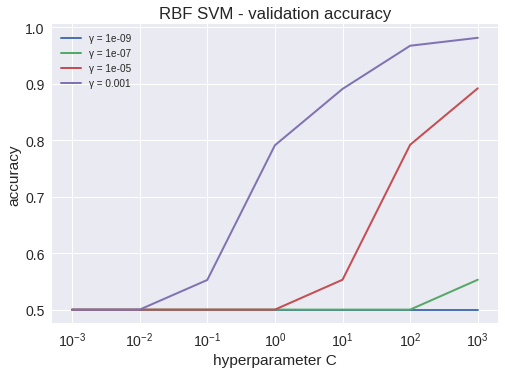

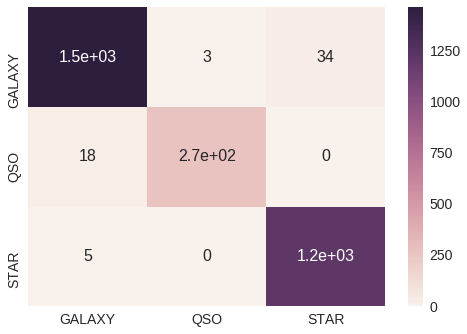

In [0]:
# ~-----RBF SVM-----
# auxiliary variables
accuracy_validation = np.zeros((C_range.shape[0], gamma_range.shape[0]))
score_max = 0
C_best_rbf = 0
gamma_best_rbf = 0


# optimizes parameters
print("============ RBF SVM ============")
for i,C in enumerate(C_range):
  for j,gamma in enumerate(gamma_range):
    model = svm.SVC(kernel='rbf', gamma=gamma, C=C)
    scores = cross_val_score(model, X_train, y_train, cv=10)
    avg = np.mean(scores)
    accuracy_validation[i][j] = avg
    print("C=" + str(C) + "   \tgamma=" + str(gamma) + "   \t--> %.2f%%" % (avg*100))
    if (avg > score_max):
        score_max = avg
        C_best_rbf = C
        gamma_best_rbf = gamma


# ~-----create best SVM-----
# train model
svc_rbf = svm.SVC(kernel='rbf', gamma=gamma_best_rbf, C=C_best_rbf)
svc_rbf.fit(X_train, y_train)

# evaluate classificator on testing set
accuracy = svc_rbf.score(X_test, y_test)


# ~-----visualize results-----
# validation accuracy
print('\n')
header = 'C\gamma   \t'
for gamma in gamma_range:
  header = header + str(gamma) + '\t'
print (header)
for i,C in enumerate(C_range):
  line = str(C) + '      \t'
  for j,gamma in enumerate(gamma_range):
    line = line + '%.2f%%' % (accuracy_validation[i][j]*100) + '\t'
  print(line)

# final accuracy
print("\nBest C=   \t" + str(C_best_rbf))
print("Best gamma= \t" + str(gamma_best_rbf))
print("Test accuracy= \t%.2f%%" % (accuracy*100))

# accuracy w.r.t. parameters
fig = plt.figure()
ax = fig.gca()
for i,gamma in enumerate(gamma_range):
  plt.plot(C_range, accuracy_validation[:,i], linewidth=2, label='γ = ' + str(gamma))
plt.xscale("log")
plt.title('RBF SVM - grid search')
plt.xlabel('Hyperparameter C')
plt.ylabel('Accuracy (cross-validation)')
ax.legend()

plt.show()


# ~-----confusion matrix-----
# compute confusion matrix
y_pred = svc_rbf.predict(X_test)
conf_mtx = confusion_matrix(y_test, y_pred)

# plot confusion matrix
df_cm = pd.DataFrame(conf_mtx, index = [i for i in classes],
                  columns = [i for i in classes])
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size